# Integrated gradients for Mnist

In this notebook we apply the integrated gradients method to a convolutional network trained on the mnist dataset. 

A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in [here](https://arxiv.org/abs/1703.01365).

In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.0
Eager execution enabled:  True


In [60]:
def plot_attributions(model, data, labels, attrs, figsize=(20, 15)):
    
    ncols = 4
    nrows = 3
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    n_subplot = 1

    for i in [0, 1, 9]:
        X_i = data[i]
        attrs_i = attrs[i]
        attrs_plus_i = attrs_i.copy()
        attrs_minus_i = -attrs_i.copy()
        attrs_plus_i[attrs_plus_i < 0] = 0
        attrs_minus_i[attrs_minus_i < 0] = 0
        
        label = labels[i]
        pred = np.argmax(model(X_i.reshape((1, ) + X_i.shape)).numpy(), axis=1)
        
        # original image
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Original image. \n True label: persian cat. \n Model prediction: {}'.format(pred[0]))
        else:
            plt.title('\n Model prediction: {}'.format(pred))
        
        plt.imshow(np.squeeze(X_i), cmap='gray')
        n_subplot += 1
        
        # all attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('All Attributions')
        plt.imshow(np.squeeze(attrs_i), cmap='gray')
        n_subplot += 1

        # positive attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0:
            plt.title('Positive Attributions')
        plt.imshow(np.squeeze(attrs_plus_i), cmap='gray')
        n_subplot += 1

        # negative attributions
        plt.subplot(nrows, ncols, n_subplot)
        if i == 0 :
            plt.title('Negative Attributions')
        plt.imshow(np.squeeze(attrs_minus_i), cmap='gray')
        n_subplot += 1
   
    plt.show()

## Load data

Loading and preparing the mnist data set.

In [61]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Training a convolutional neural network on the mnist dataset. The model include 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `../model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [6]:
load_mnist_model = False
save_model = True

In [7]:
filepath = './model_mnist/'  # change to directory where model is downloaded
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

Train on 60000 samples, validate on 10000 samples
Epoch 1/6
60000/60000 [==============================] - 7s 121us/sample - loss: 0.5028 - acc: 0.8402 - val_loss: 0.1345 - val_acc: 0.9595
Epoch 2/6
60000/60000 [==============================] - 5s 82us/sample - loss: 0.1756 - acc: 0.9455 - val_loss: 0.0811 - val_acc: 0.9723
Epoch 3/6
60000/60000 [==============================] - 5s 82us/sample - loss: 0.1230 - acc: 0.9612 - val_loss: 0.0571 - val_acc: 0.9805
Epoch 4/6
60000/60000 [==============================] - 5s 83us/sample - loss: 0.1035 - acc: 0.9676 - val_loss: 0.0460 - val_acc: 0.9857
Epoch 5/6
60000/60000 [==============================] - 5s 83us/sample - loss: 0.0877 - acc: 0.9728 - val_loss: 0.0429 - val_acc: 0.9857
Epoch 6/6
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0778 - acc: 0.9761 - val_loss: 0.0369 - val_acc: 0.9882


## Calculate integrated gradients

The IntegratedGradients class implements the integrated gradients features attribution method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb).

In the following example, the baselines (i. e. the starting points of the gradients' integral) are black images (all pixel's values are set to zero). This means that black areas of the image will always have zero attributions.
The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [8]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

In [31]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_red = X_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]
explanation = ig.explain(X_test_red, 
                         baselines=None, 
                         target=test_labels_red,
                         return_convergence_delta=return_convergence_delta, 
                         return_predictions=return_predictions)

In [32]:
# Get attributions values from the explanation object
attributions = explanation.data['attributions']

## Visualize attributions

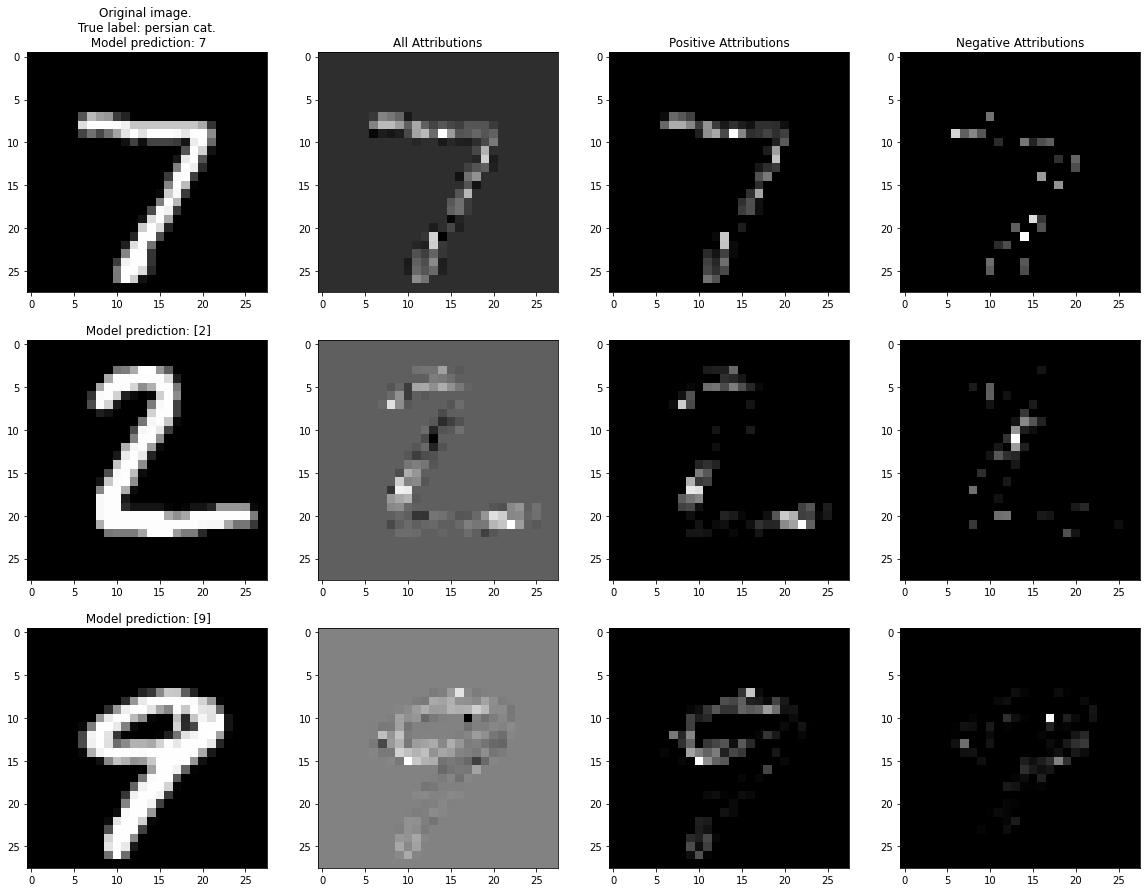

In [58]:
plot_attributions(model, X_test, test_labels, attributions, figsize=(20, 15))